In [2]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import cv2
import os
import numpy as np
from PIL import Image
import matplotlib as plt
# Read recipe inputs
svp_clusters = dataiku.Folder("hAbB1mJR")
svp_clusters_info = svp_clusters.get_info()


# Compute recipe outputs
# TODO: Write here your actual code that computes the outputs
# NB: DSS supports several kinds of APIs for reading and writing data. Please see doc.

# cnn_result_df = ... # Compute a Pandas dataframe to write into CNN_result


# # Write recipe outputs
# cnn_result = dataiku.Dataset("CNN_result")
# cnn_result.write_with_schema(cnn_result_df)

In [3]:
import os
conn_folder = dataiku.Folder('hAbB1mJR')
all_files_paths = conn_folder.list_paths_in_partition()
image_paths = [file_path for file_path in all_files_paths if file_path.endswith(".jpg")]
label_names = []
resized_images = []
for idx ,image_path in enumerate(image_paths):
    label_name = os.path.basename(image_path)[:2]
    pil_image=Image.open(conn_folder.get_download_stream(image_path))
    #resized_img = pil_image.resize((20,20))
    resized_images.append(pil_image)
    label_names.append(label_name)
    if idx == 10:
        break

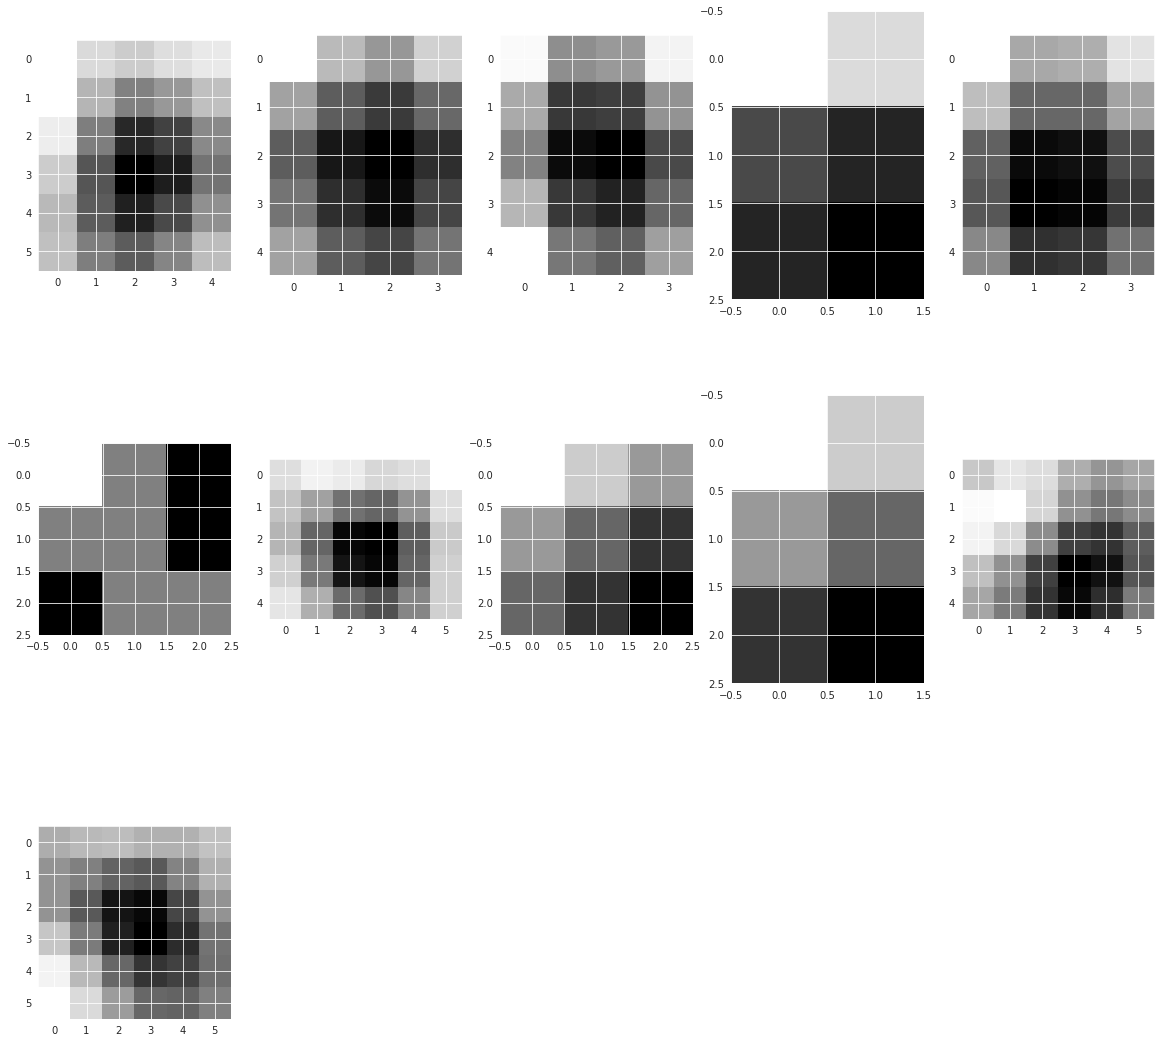

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
columns = 5
for i, image in enumerate(resized_images):
    plt.subplot(len(resized_images) / columns + 1, columns, i + 1)
    plt.imshow(image, cmap = 'gray')


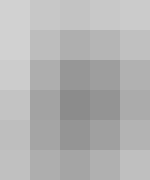
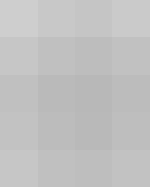
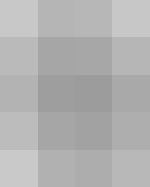
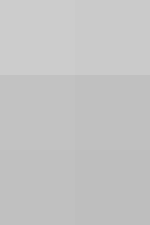
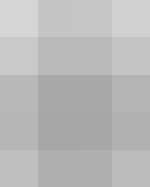
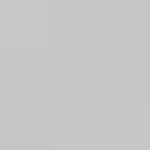
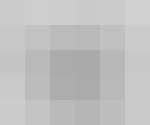
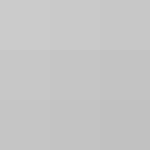
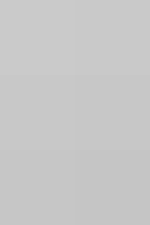
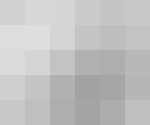
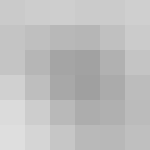


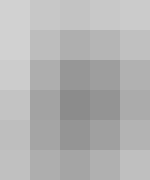
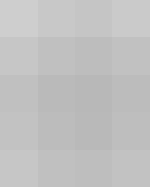
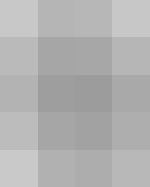
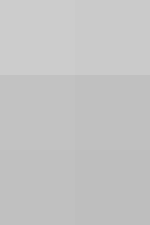
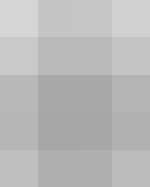
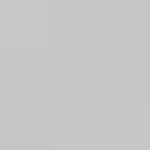
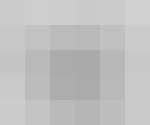
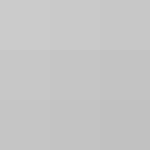
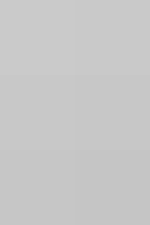
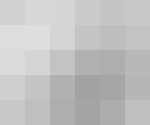
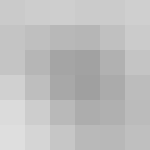

In [5]:
import ipyplot

ipyplot.plot_images(resized_images, max_images=20, img_width=150)

In [10]:
from numpy import asarray
labels = ['protein', 'silicon']
img_size = 20

def get_data(image_paths):
    data = []
    labels = []
    sil_cnt = 0
    prot_cnt = 0
    for image_path in image_paths:
            try:
                label_name = os.path.basename(image_path)[:2]
                if label_name == 'p5':
                    class_num = 0
                    prot_cnt+=1
                    if prot_cnt > 7600:
                         continue
                else:
                    class_num = 1
                if sil_cnt >= 7600 and prot_cnt >= 7600:
                    break
                pil_image=Image.open(conn_folder.get_download_stream(image_path))
                resized_img = pil_image.resize((20,20))
                resized_img = np.expand_dims(resized_img, axis=-1)
                resized_arr = asarray(resized_img)
                data.append(resized_arr)
                labels.append(class_num)
            except Exception as e:
                print(e)

    return np.array(data),labels
X,y = get_data(image_paths)

Protein_Images _Count : 7600
Silicon_Images_Count : 7620


/hadoopfs/fs1/dataiku/data_dir/code-envs/python/Python36-GPU/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


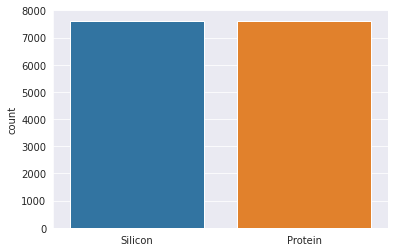

In [13]:
import seaborn as sns
l = []
protein_cnt = 0
for i in y:
    if(i == 0):
        l.append("Protein")
        protein_cnt +=1
    else:
        l.append("Silicon")
print("Protein_Images _Count :",protein_cnt)
print("Silicon_Images_Count :",len(y) - protein_cnt)
sns.set_style('darkgrid')
sns.countplot(l)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)
print(X_train.shape)

(10197, 20, 20, 1)


In [15]:
model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(20,20,1)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

opt = Adam(lr=0.000001)
model.compile(optimizer = opt , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



/hadoopfs/fs1/dataiku/data_dir/code-envs/python/Python36-GPU/lib/python3.6/site-packages/tensorflow_core/python/framework/tensor_util.py:521: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  tensor_proto.tensor_content = nparray.tostring()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 64)          18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 64)         

In [ ]:
learning_rate = [0.001,0.01,0.1, 1, 10, 10e3]
opt = [adam, rmsprop, momemtum]

# Bayesian, gridsearch, random search

In [19]:
history = model.fit(X_train,y_train,epochs = 500 , validation_data = (X_test, y_test))

Train on 10197 samples, validate on 5023 samples
Epoch 1/500
10197/10197 [==============================] - 3s 267us/step - loss: 0.7619 - accuracy: 0.5652 - val_loss: 0.7390 - val_accuracy: 0.0000e+00
Epoch 2/500
10197/10197 [==============================] - 3s 249us/step - loss: 0.7536 - accuracy: 0.5559 - val_loss: 0.7246 - val_accuracy: 1.9908e-04
Epoch 3/500
10197/10197 [==============================] - 3s 247us/step - loss: 0.7608 - accuracy: 0.5637 - val_loss: 0.6596 - val_accuracy: 0.0677
Epoch 4/500
10197/10197 [==============================] - 2s 245us/step - loss: 0.7619 - accuracy: 0.5782 - val_loss: 0.6853 - val_accuracy: 0.0213
Epoch 5/500
10197/10197 [==============================] - 3s 258us/step - loss: 0.7563 - accuracy: 0.5547 - val_loss: 0.6867 - val_accuracy: 0.0211
Epoch 6/500
10197/10197 [==============================] - 3s 258us/step - loss: 0.7500 - accuracy: 0.5708 - val_loss: 0.6958 - val_accuracy: 0.0052
Epoch 7/500
10197/10197 [========================

10197/10197 [==============================] - 3s 254us/step - loss: 0.6643 - accuracy: 0.6097 - val_loss: 0.5490 - val_accuracy: 0.4649
Epoch 110/500
10197/10197 [==============================] - 2s 245us/step - loss: 0.6653 - accuracy: 0.6054 - val_loss: 0.5332 - val_accuracy: 0.5718
Epoch 111/500
10197/10197 [==============================] - 3s 246us/step - loss: 0.6499 - accuracy: 0.6176 - val_loss: 0.5348 - val_accuracy: 0.5397
Epoch 112/500
10197/10197 [==============================] - 3s 258us/step - loss: 0.6541 - accuracy: 0.6305 - val_loss: 0.5336 - val_accuracy: 0.5572
Epoch 113/500
10197/10197 [==============================] - 3s 259us/step - loss: 0.6586 - accuracy: 0.6131 - val_loss: 0.5331 - val_accuracy: 0.5702
Epoch 114/500
10197/10197 [==============================] - 3s 247us/step - loss: 0.6503 - accuracy: 0.6363 - val_loss: 0.5362 - val_accuracy: 0.5178
Epoch 115/500
10197/10197 [==============================] - 3s 247us/step - loss: 0.6469 - accuracy: 0.6046

10197/10197 [==============================] - 3s 268us/step - loss: 0.5543 - accuracy: 0.5881 - val_loss: 0.5194 - val_accuracy: 0.4633
Epoch 218/500
10197/10197 [==============================] - 3s 275us/step - loss: 0.5529 - accuracy: 0.5844 - val_loss: 0.5212 - val_accuracy: 0.4555
Epoch 219/500
10197/10197 [==============================] - 3s 264us/step - loss: 0.5530 - accuracy: 0.5929 - val_loss: 0.5085 - val_accuracy: 0.5011
Epoch 220/500
10197/10197 [==============================] - 3s 262us/step - loss: 0.5494 - accuracy: 0.5938 - val_loss: 0.5042 - val_accuracy: 0.5204
Epoch 221/500
10197/10197 [==============================] - 3s 269us/step - loss: 0.5526 - accuracy: 0.5919 - val_loss: 0.5102 - val_accuracy: 0.4907
Epoch 222/500
10197/10197 [==============================] - 3s 271us/step - loss: 0.5484 - accuracy: 0.5918 - val_loss: 0.5085 - val_accuracy: 0.4967
Epoch 223/500
10197/10197 [==============================] - 3s 271us/step - loss: 0.5500 - accuracy: 0.5910

10197/10197 [==============================] - 3s 299us/step - loss: 0.4652 - accuracy: 0.5703 - val_loss: 0.4509 - val_accuracy: 0.5005
Epoch 326/500
10197/10197 [==============================] - 3s 311us/step - loss: 0.4651 - accuracy: 0.5663 - val_loss: 0.4464 - val_accuracy: 0.5138
Epoch 327/500
10197/10197 [==============================] - 3s 294us/step - loss: 0.4649 - accuracy: 0.5575 - val_loss: 0.4561 - val_accuracy: 0.4860
Epoch 328/500
10197/10197 [==============================] - 3s 294us/step - loss: 0.4663 - accuracy: 0.5678 - val_loss: 0.4466 - val_accuracy: 0.5093
Epoch 329/500
10197/10197 [==============================] - 3s 306us/step - loss: 0.4617 - accuracy: 0.5681 - val_loss: 0.4556 - val_accuracy: 0.4858
Epoch 330/500
10197/10197 [==============================] - 3s 314us/step - loss: 0.4648 - accuracy: 0.5658 - val_loss: 0.4560 - val_accuracy: 0.4836
Epoch 331/500
10197/10197 [==============================] - 3s 301us/step - loss: 0.4612 - accuracy: 0.5626

10197/10197 [==============================] - 3s 246us/step - loss: 0.4205 - accuracy: 0.5518 - val_loss: 0.4084 - val_accuracy: 0.5158
Epoch 434/500
10197/10197 [==============================] - 3s 251us/step - loss: 0.4204 - accuracy: 0.5503 - val_loss: 0.4116 - val_accuracy: 0.5069
Epoch 435/500
10197/10197 [==============================] - 3s 271us/step - loss: 0.4208 - accuracy: 0.5491 - val_loss: 0.4056 - val_accuracy: 0.5236
Epoch 436/500
10197/10197 [==============================] - 3s 258us/step - loss: 0.4221 - accuracy: 0.5536 - val_loss: 0.4086 - val_accuracy: 0.5142
Epoch 437/500
10197/10197 [==============================] - 3s 256us/step - loss: 0.4200 - accuracy: 0.5514 - val_loss: 0.4125 - val_accuracy: 0.5035
Epoch 438/500
10197/10197 [==============================] - 3s 248us/step - loss: 0.4203 - accuracy: 0.5479 - val_loss: 0.4102 - val_accuracy: 0.5085
Epoch 439/500
10197/10197 [==============================] - 3s 269us/step - loss: 0.4179 - accuracy: 0.5516

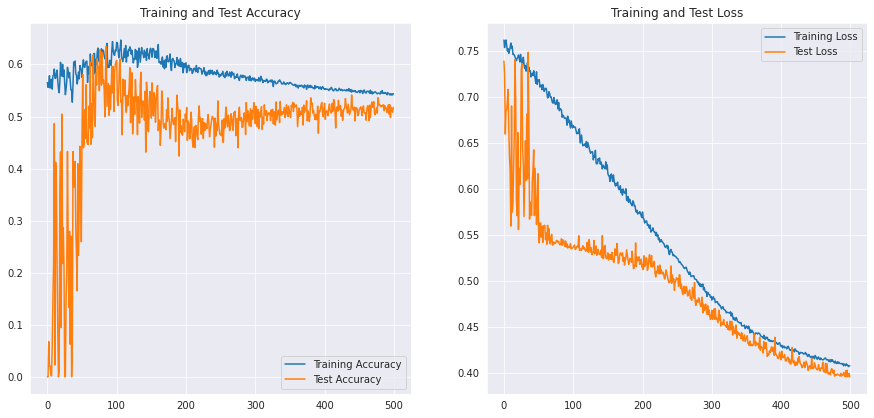

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.show()

In [24]:
predictions = model.predict_classes(X_test)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['Protein','Silicon']))

              precision    recall  f1-score   support

     Protein       0.92      0.95      0.93      2500
     Silicon       0.95      0.91      0.93      2523

   micro avg       0.93      0.93      0.93      5023
   macro avg       0.93      0.93      0.93      5023
weighted avg       0.93      0.93      0.93      5023



In [ ]:
#Transfer Learning

base_model = tf.keras.applications.MobileNetV2(input_shape = (20, 20, 1), include_top = False, weights = "imagenet")

base_model.trainable = False

model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(2, activation="softmax")                                     
                                ])

In [ ]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

transfer_history = model.fit(X_train,y_train,epochs = 500 , validation_data = (X_test, y_test))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Test Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Test Loss')
plt.show()

In [ ]:
predictions = model.predict_classes(X_test)
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions, target_names = ['Protein','Silicon']))